<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'plotly_white'

In [2]:
focus = 'Lung Cancer'

In [3]:
network = pd.read_csv('data/cell_lines_corr-above0-5-0-323.net', sep='\t')

In [4]:
network.shape

(186, 3)

In [5]:
nodes = pd.read_csv('data/cell_lines_corr-above0-5-0-323.nodes', sep='\t')

In [6]:
focus_IDs = list(nodes[nodes['Primary Disease']==focus]['Node_ID'])

In [7]:
cancer_lookup = dict(zip(nodes['Node_ID'], nodes['Primary Disease']))

In [8]:
cell_line_lookup = dict(zip(nodes['Node_ID'], nodes['DepMap_ID']))

In [9]:
focus_network = network[network['#SOURCE'].isin(focus_IDs) | network['#TARGET'].isin(focus_IDs)].copy()

In [10]:
focus_network['#SOURCE_Cancer']=[cancer_lookup[i] for i in focus_network['#SOURCE']]
focus_network['#TARGET_Cancer']=[cancer_lookup[i] for i in focus_network['#TARGET']]
focus_network['#SOURCE_Cell_Line']=[cell_line_lookup[i] for i in focus_network['#SOURCE']]
focus_network['#TARGET_Cell_Line']=[cell_line_lookup[i] for i in focus_network['#TARGET']]

In [11]:
top_5 = focus_network.sort_values(by='#WEIGHT', ascending=False).head(5)

In [12]:
top_5

,#SOURCE,#TARGET,#WEIGHT,#SOURCE_Cancer,#TARGET_Cancer,#SOURCE_Cell_Line,#TARGET_Cell_Line
151,346,438,0.877214,Ovarian Cancer,Lung Cancer,ACH-000696,ACH-000853
52,390,298,0.843455,Lung Cancer,Pancreatic Cancer,ACH-000781,ACH-000601
132,105,398,0.839729,Pancreatic Cancer,Lung Cancer,ACH-000243,ACH-000791
119,466,468,0.831021,Lung Cancer,Ovarian Cancer,ACH-000901,ACH-000906
9,427,298,0.830343,Lung Cancer,Pancreatic Cancer,ACH-000837,ACH-000601


In [13]:
ranks = pd.read_csv('data/gene_dependency_ranks_above_0-5.csv',index_col=[0])

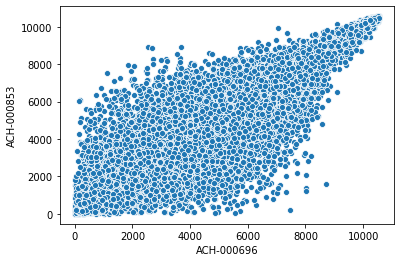

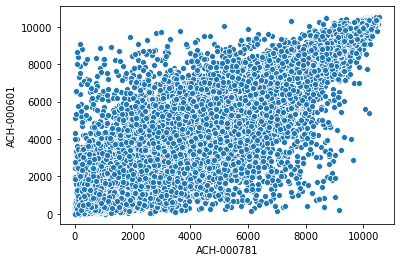

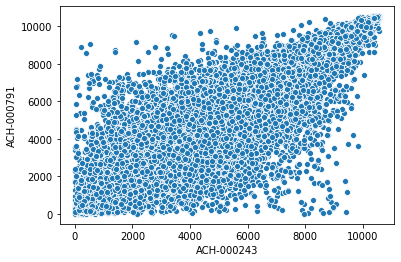

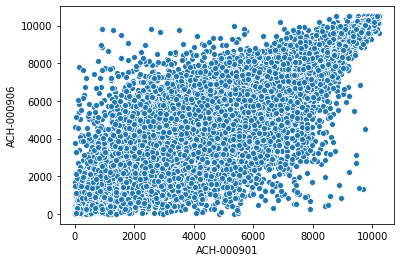

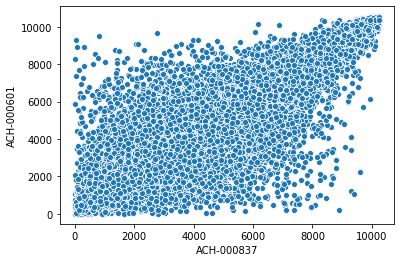

In [14]:
for index, row in top_5.iterrows():
    plt.figure()
    ax = sns.scatterplot(ranks[row['#SOURCE_Cell_Line']],ranks[row['#TARGET_Cell_Line']])

In [15]:
drugs = pd.read_csv('data/listofdrugs.csv')

In [16]:
drugs['genes_list']=[list(filter(None, x.split('|'))) for x in drugs['genes']]

In [17]:
gene_targets = pd.DataFrame(columns=['genes','drug'])

In [18]:
for index, row in drugs.iterrows():
    targets = []
    for gene in row['genes_list']:
        targets.extend(list(filter(lambda x: gene in x, list(ranks.index))))
    gene_targets = gene_targets.append({'genes':targets,'drug':row['drug_name']},ignore_index=True)

In [19]:
gene_targets.to_csv('data/gene_targets.csv')

In [20]:
targetable = []
for g in gene_targets['genes']:
    targetable.extend(g)

In [54]:
not_targetable = []
for g in ranks.index:
    if g not in targetable:
        not_targetable.append(g)

In [62]:
print(f'targetable:\t{len(targetable)} \nnot targetable:\t{len(not_targetable)}')

targetable:	386 
not targetable:	10369


In [21]:
f=open('data/targetable.list','w')
l=','.join(targetable)
f.write(l)
f.close()

In [22]:
cell_line_to_cancer_type = dict(zip(nodes['DepMap_ID'], nodes['Primary Disease']))

In [23]:
target_to_drug = {}

In [24]:
for index, row in gene_targets.iterrows():
    for g in row['genes']:
        target_to_drug[g]=row['drug']

In [25]:
top_5

,#SOURCE,#TARGET,#WEIGHT,#SOURCE_Cancer,#TARGET_Cancer,#SOURCE_Cell_Line,#TARGET_Cell_Line
151,346,438,0.877214,Ovarian Cancer,Lung Cancer,ACH-000696,ACH-000853
52,390,298,0.843455,Lung Cancer,Pancreatic Cancer,ACH-000781,ACH-000601
132,105,398,0.839729,Pancreatic Cancer,Lung Cancer,ACH-000243,ACH-000791
119,466,468,0.831021,Lung Cancer,Ovarian Cancer,ACH-000901,ACH-000906
9,427,298,0.830343,Lung Cancer,Pancreatic Cancer,ACH-000837,ACH-000601


In [26]:
directory = 'figures/cell-line_drug-targets/'

In [41]:
drugs[drugs['drug_name']=='MK-1775']['genes_list']

108    [WEE1, PLK1]
Name: genes_list, dtype: object

In [64]:
for index, row in top_5.iterrows():
    src = row['#SOURCE_Cell_Line']
    tgt = row['#TARGET_Cell_Line']
    xlabel = str('Gene Rank for '+row['#SOURCE_Cell_Line']+' ('+row['#SOURCE_Cancer']+')')
    ylabel = str('Gene Rank for '+row['#TARGET_Cell_Line']+' ('+row['#TARGET_Cancer']+')')
    
    shared_targets = ranks.filter([src,tgt]).filter(targetable, axis=0)
    shared_targets['drug'] = [target_to_drug[i] for i in list(shared_targets.index)]
    shared_targets['all_targets']= [drugs[drugs['drug_name']==drug]['genes_list'] for drug in shared_targets['drug']]
    shared_targets = shared_targets.sort_values(by=src, ascending=False)
    fig = px.scatter(shared_targets,
                     x=src,
                     y=tgt,
                     color='drug',
                     hover_name=shared_targets.index,
                     hover_data=[shared_targets['all_targets']])
    fig.update_traces(marker=dict(size=12,opacity=0.8,line=dict(width=1,color='DarkSlateGrey')))
    fig.update_layout(
        xaxis=dict(title=xlabel),
        yaxis=dict(title=ylabel),
        title=str("Gene Ranks for "+src+" vs "+tgt))
    fig.write_image(str(directory+src+"_"+tgt+".svg"))
    fig.write_image(str(directory+src+"_"+tgt+".png"))
    fig.show()